# Фаза 2 • Неделя 8 • Среда
## Нейронные сети
### 🔥 PyTorch: сверточные сети

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

# Тут много разных аугментаций
# https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py
from torchvision import transforms as T
import torchutils as tu


import mplcyberpunk
import matplotlib.pyplot as plt
import numpy as np

import mlflow      
import mlflow.pytorch  


torch.manual_seed(42)
plt.style.use('cyberpunk')

## PyTorch example

#### 0. Config 

In [35]:
config = {
    'batch_size': 1024,
    'learning_rate': 0.003,
    'epochs': 15,
    'device': 'mps',  # 'cuda' if torch.cuda.is_available() else 'cpu'
    'data_dir': 'data/',
    'log_dir': 'runs/experiment1'
}

# ниже строка не обязательна, но часто device хранят еще и в отдельной переменной, так как часто обращаются к ней
DEVICE = config['device'] #'cuda' if torch.cuda.is_available() else 'cpu'

#### 1. Dataset

In [36]:
train_dataset = MNIST(
        config['data_dir'], 
        train=True,
        download=True,
        transform=T.Compose( 
              [
                T.RandomRotation(80),  
                T.RandomPerspective(),
                T.ToTensor(), # x in range(0, 1)
                
                # Среднее будет в 0, ст. отклонение будет 1
                T.Normalize(mean=(0.1307,), std=(0.3081, ))
              ]
            )
          )

valid_dataset = MNIST(
        config['data_dir'], 
        train=False, 
        download=True,
        transform=T.Compose(
                [
                  T.ToTensor(),
                  T.Normalize(mean=(0.1307,), std=(0.3081,))
                ]
              )
            )

#####  🎨 Разница между `train_dataset.data[i]` и `train_dataset[i]`

В PyTorch `Dataset` мы можем обращаться к данным **двумя разными способами**:
1. **Напрямую через `.data`** → Это **сырые данные** без `transform` ❌.
2. **Через `train_dataset[i]`** → Здесь уже применены `transform` ✅.

Text(0.5, 1.0, 'Transformed image with augmentation')

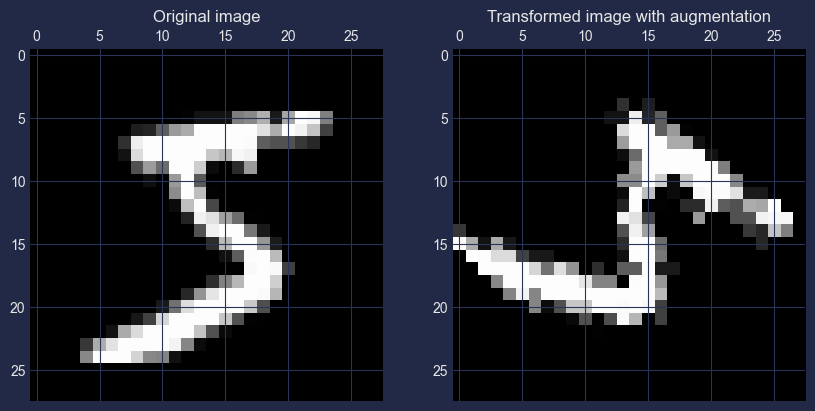

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(10, 7))

ax[0].matshow(train_dataset.data[0], cmap='grey')
ax[0].set_title('Original image')

ax[1].matshow(train_dataset[0][0].squeeze(0), cmap='grey')
ax[1].set_title('Transformed image with augmentation')

##### 🧮 Как вычислить параметры для нормализации (среднее и стандартное отклонение)?  
 

Взять все данные датасета и применить нужный метод: 
```
mean = train_dataset.data.float().mean()/255
std  = train_dataset.data.float().std()/255
```

Для многих датасетов этот параметр можно загуглить.

In [38]:
mean = train_dataset.data.float().mean() / 255 
std = train_dataset.data.float().std() / 255

print(f"Mean: {mean:.4f}, Std: {std:.4f}")

Mean: 0.1307, Std: 0.3081


Это среднее значение и стандартное отклонение пикселя в шкале от 0 до 1. 

#### 2. DataLoader

In [39]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=config['batch_size'])
valid_loader = DataLoader(valid_dataset, shuffle=True, batch_size=config['batch_size'])

📌 **Важно!** `DataLoader` **автоматически применяет** `transform` при загрузке данных.  
Если ты используешь `DataLoader`, изображения уже будут **с нормализацией** и **применёнными аугментациями**.

In [40]:
test_batch = next(iter(train_loader))
test_batch_samples, test_batch_targets = test_batch

In [41]:
# Диапозон пикселей уже нормирован и лежит со средним около нуля и стандартным отклонением около 1. 

test_batch_samples[0].mean(), test_batch_samples[0].std()

(tensor(-0.1125), tensor(0.8103))

In [42]:
# Но отображается так же, так как пропорции сохранены

# plt.matshow(test_batch_samples[0].squeeze(0), cmap='grey')

#### 3. Visualization of network learning

In [43]:
# Зададим функцию для отрисовки графиков

# зададим функцию рисования графиков
def plot_history(history, grid=True):
    fig, ax = plt.subplots(1,2, figsize=(14,5))
    
    ax[0].plot(history['train_losses'], label='train loss')
    ax[0].plot(history['valid_losses'], label='valid loss')
    ax[0].set_title(f'Loss on epoch {len(history["train_losses"])}')
    ax[0].grid(grid)
    ax[0].set_ylim((0, max(history['train_losses'] + history['valid_losses']) + .1))
    ax[0].legend()
    
    ax[1].plot(history['train_accs'], label='train acc')
    ax[1].plot(history['valid_accs'], label='valid acc')
    ax[1].set_title(f'Accuracy on epoch {len(history["train_losses"])}')
    ax[1].grid(grid)
    ax[1].set_ylim((0, 1))
    ax[1].legend()
    
    plt.show()

#### 4. Model

In [45]:
class CNN(nn.Module): 
    def __init__(self): 
        super().__init__() 
        self.layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1, # (w - k +2*p) / s + 1
                out_channels=4, 
                kernel_size=5, 
                stride=1, 
                padding=2), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(4, 8, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(8, 10, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
            # nn.AdaptiveAvgPool2d()
        )
        
        self.fc1 = nn.Linear(90, 16) 
        # self.fc1 = nn.LazyLinear(16)
        # self.drop_out = nn.Dropout() 
        self.fc2 = nn.Linear(16, 10)

        
    def forward(self, x: torch.Tensor) -> torch.Tensor: # [BATCH_SZIE=512, n_channels=1, width=28, height=28]
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1) # view flatten
        # print(out.shape)
        out = torch.sigmoid(self.fc1(out))
        # out = self.drop_out(out) 
        out = self.fc2(out)  # [BATCH_SIZE=512, n_classes = 10]
        return out
    
model = CNN()

In [46]:
tu.get_model_summary(model.to(DEVICE), test_batch_samples.to(DEVICE))

Layer                     Kernel            Output         Params         FLOPs
0_layer1.Conv2d_0       [1, 4, 5, 5]   [1024, 4, 28, 28]      104    83,492,864
1_layer1.ReLU_1                    -   [1024, 4, 28, 28]        0             0
2_layer1.MaxPool2d_2               -   [1024, 4, 14, 14]        0             0
3_layer2.Conv2d_0       [4, 8, 5, 5]   [1024, 8, 14, 14]      808   162,168,832
4_layer2.ReLU_1                    -   [1024, 8, 14, 14]        0             0
5_layer2.MaxPool2d_2               -     [1024, 8, 7, 7]        0             0
6_layer3.Conv2d_0      [8, 10, 5, 5]    [1024, 10, 7, 7]    2,010   100,853,760
7_layer3.ReLU_1                    -    [1024, 10, 7, 7]        0             0
8_layer3.MaxPool2d_2               -    [1024, 10, 3, 3]        0             0
9_fc1                       [90, 16]          [1024, 16]    1,456     2,932,736
10_fc2                      [16, 10]          [1024, 10]      170       317,440
Total params: 4,548
Trainable params: 4,

#### 5. MLFlow (для логирования экспериментов)

 - **MLflow UI** доступен по порту `5000` 🌐, где вы можете логировать и отслеживать эксперименты и метрики.
- Все логи и модели сохраняются в папке `mlruns` 📂, что позволяет легко управлять результатами экспериментов.

In [78]:
# [MLflow] Флажок, чтобы включать/выключать логирование
use_mlflow = True

# Здесь можно выбрать или задать название эксперимента
# (если такового нет, MLflow создаст новый)
mlflow_experiment_name = "MNIST-CNN-Experiment"

#### 6. Optimizer and Loss

In [79]:
optimizer = torch.optim.Adam(model.parameters(), config['learning_rate'])
criterion = torch.nn.CrossEntropyLoss()

#### 7. Model fitting 

In [80]:
# Функция обучения
def fit_model(
        model: nn.Module, 
        epochs: int, 
        optimizer: torch.optim.Optimizer, 
        history=None
    ):
    history = history or {
        'train_accs': [],
        'train_losses': [],
        'valid_accs': [],
        'valid_losses': [],
    }

    for epoch in range(1, epochs + 1):
        model.train()
        batch_losses = []
        batch_accs = []
        
        for samples, labels in train_loader:
            samples = samples.to(DEVICE)
            labels = labels.to(DEVICE)
            
            y_pred = model(samples)
            loss = criterion(y_pred, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
            batch_accs.append((y_pred.argmax(dim=1) == labels).float().mean().item())

        train_loss = np.mean(batch_losses)
        train_acc  = np.mean(batch_accs)
        history['train_losses'].append(train_loss)
        history['train_accs'].append(train_acc)

        model.eval()
        batch_losses = []
        batch_accs = []
        with torch.no_grad():
            for samples, labels in valid_loader:
                samples = samples.to(DEVICE)
                labels = labels.to(DEVICE)
                y_pred = model(samples)
                loss = criterion(y_pred, labels)
                batch_losses.append(loss.item())
                batch_accs.append((y_pred.argmax(dim=1) == labels).float().mean().item())

        valid_loss = np.mean(batch_losses)
        valid_acc  = np.mean(batch_accs)
        history['valid_losses'].append(valid_loss)
        history['valid_accs'].append(valid_acc)

        # [MLflow] Логируем метрики
        if use_mlflow:
            # epoch – номер шага (можно указывать step=epoch)
            mlflow.log_metric("train_loss", train_loss, step=epoch)
            mlflow.log_metric("train_acc",  train_acc,  step=epoch)
            mlflow.log_metric("valid_loss", valid_loss, step=epoch)
            mlflow.log_metric("valid_acc",  valid_acc,  step=epoch)

        print(
            f"Epoch {epoch}/{epochs} | "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
            f"Val Loss: {valid_loss:.4f}, Val Acc: {valid_acc:.4f}"
        )

    plot_history(history)
    return history


Epoch 1/15 | Train Loss: 2.1697, Train Acc: 0.2493 | Val Loss: 1.8261, Val Acc: 0.5043
Epoch 2/15 | Train Loss: 1.7392, Train Acc: 0.4741 | Val Loss: 1.3225, Val Acc: 0.6701
Epoch 3/15 | Train Loss: 1.3827, Train Acc: 0.5994 | Val Loss: 0.9809, Val Acc: 0.7776
Epoch 4/15 | Train Loss: 1.1568, Train Acc: 0.6683 | Val Loss: 0.7800, Val Acc: 0.8165
Epoch 5/15 | Train Loss: 0.9906, Train Acc: 0.7208 | Val Loss: 0.6259, Val Acc: 0.8617
Epoch 6/15 | Train Loss: 0.8642, Train Acc: 0.7572 | Val Loss: 0.5356, Val Acc: 0.8764
Epoch 7/15 | Train Loss: 0.7759, Train Acc: 0.7788 | Val Loss: 0.4437, Val Acc: 0.8958
Epoch 8/15 | Train Loss: 0.7020, Train Acc: 0.7991 | Val Loss: 0.4030, Val Acc: 0.8980
Epoch 9/15 | Train Loss: 0.6548, Train Acc: 0.8094 | Val Loss: 0.3558, Val Acc: 0.9127
Epoch 10/15 | Train Loss: 0.6017, Train Acc: 0.8231 | Val Loss: 0.3265, Val Acc: 0.9181
Epoch 11/15 | Train Loss: 0.5740, Train Acc: 0.8311 | Val Loss: 0.3260, Val Acc: 0.9128
Epoch 12/15 | Train Loss: 0.5316, Train A

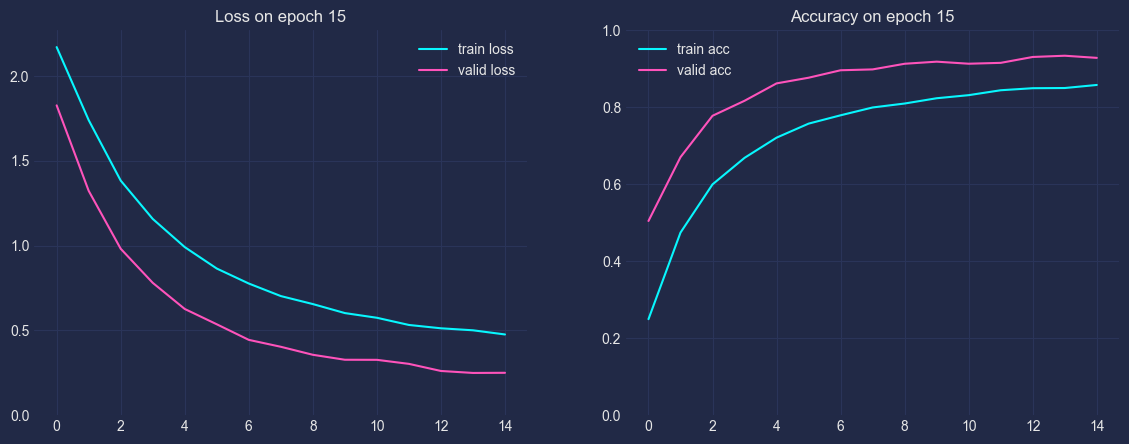

2025/02/06 14:37:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [50]:
# [MLflow] Запуск эксперимента через контекстный менеджер
if use_mlflow:
    mlflow.set_experiment(mlflow_experiment_name)  # установить (или создать) эксперимент
    with mlflow.start_run(run_name="MNIST_CNN_bs_1024_lr_0.002"):
        # Логируем гиперпараметры из config
        mlflow.log_param("batch_size",      config['batch_size'])
        mlflow.log_param("learning_rate",   config['learning_rate'])
        mlflow.log_param("epochs",          config['epochs'])
        mlflow.log_param("device",          config['device'])

        # Запускаем обучение
        logs = fit_model(model, config['epochs'], optimizer)

        # Сохраняем модель в MLflow (опционально)
        mlflow.pytorch.log_model(model, "model")

    # После выхода из `with` Run автоматически завершается
else:
    # Если не используем MLflow
    logs = fit_model(model, config['epochs'], optimizer)

#### 8. Model Inference (Прогноз модели)

In [56]:
# делаем из генератора итерируемый объект и достаем оттуда один элемент
img, true_label = next(iter(valid_loader))

In [57]:
print(img.shape)
print(true_label[0])

torch.Size([1024, 1, 28, 28])
tensor(8)


<b>Возьмем одну картинку из батча и првоерим</b>

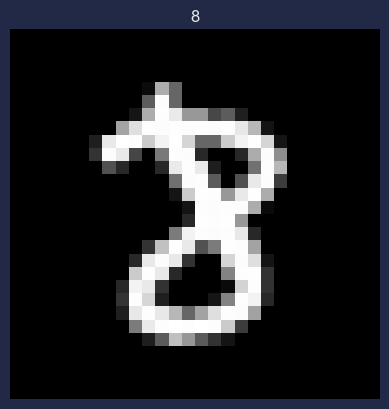

In [58]:
plt.imshow(img[0][0], cmap='gray')
plt.title(f'{true_label[0]}'); plt.axis('off');

Чтобы получить предсказание на одной картинке, нужно привести данные в формат, в котором модель может принять картинку на вход. Обучение модели проходило на данных формата `[BATCH_SIZE, n_channels, height, width]`. Формат одной картинки – `[n_channels, height, width]` – не хватает одного измерения на первом месте. В таком случае мы сделаем вид, что у нас просто батч из одной картинки – это можно сделать с помощью метода `img.unsqueeze(n)`, где `n` – позиция, на которую надо поставить фиктивную единицу, в нашем случае эта позиция – `BATCH_SIZE`, то есть 0. 

In [66]:
img[0].unsqueeze(0).shape

torch.Size([1, 1, 28, 28])

In [72]:
with torch.inference_mode():
    pred_class = model(img[0].unsqueeze(0).to(DEVICE)).softmax(dim=1).argmax().item()
print(f'Pred class: {pred_class}')

Pred class: 2


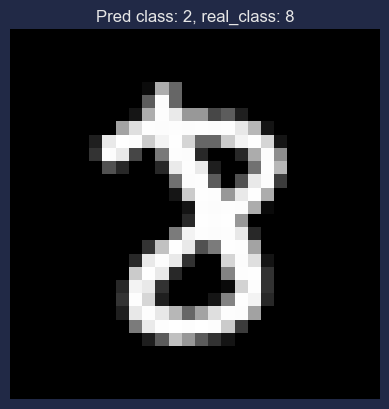

In [74]:
plt.imshow(img[0][0], cmap='gray')
plt.title(f'Pred class: {pred_class}, real_class: {true_label[0]}'); 
plt.axis('off');

## Feature extraction (Feature Map)

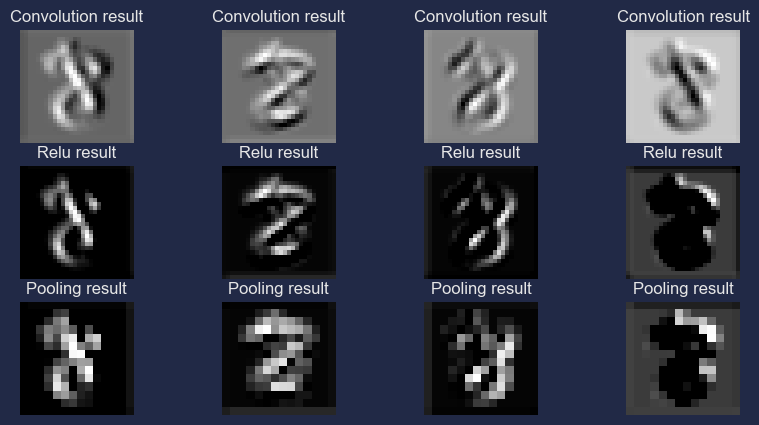

In [75]:
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
model.cpu()
train_nodes, _ = get_graph_node_names(model)
feature_extractor = create_feature_extractor(
	model, return_nodes=[
			'layer1.0', 'layer1.1', 'layer1.2', 'layer2.0', 'layer2.1', 'layer2.2'
	]
)
out = feature_extractor(img)
# plt.imshow(img[0, 0].detach().cpu().numpy(), cmap='gray')
# plt.axis('off')
fig, ax = plt.subplots(3, 4, figsize=(10, 5))
for i in range(4):
    ax[0, i].axis('off')
    ax[0, i].set_title('Convolution result')
    ax[0, i].imshow(out['layer1.0'][0, i, :, :].detach().cpu().numpy(), cmap='gray')
    ax[1, i].axis('off')
    ax[1, i].set_title('Relu result')
    ax[1, i].imshow(out['layer1.1'][0, i, :, :].detach().cpu().numpy(), cmap='gray')
    ax[2, i].axis('off')
    ax[2, i].set_title('Pooling result')
    ax[2, i].imshow(out['layer1.2'][0, i, :, :].detach().cpu().numpy(), cmap='gray')

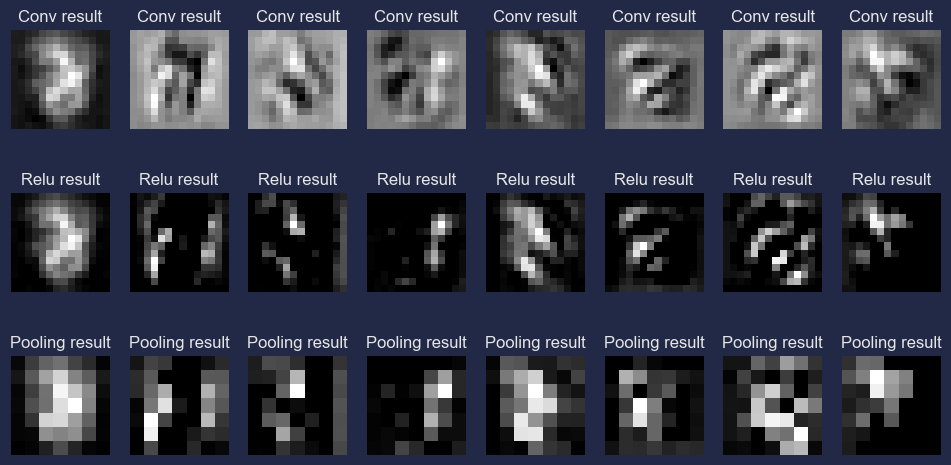

In [76]:
fig, ax = plt.subplots(3, 8, figsize=(12, 6))
for i in range(8):
    ax[0, i].axis('off')
    ax[0, i].set_title('Conv result')
    ax[0, i].imshow(out['layer2.0'][0, i, :, :].detach().cpu().numpy(), cmap='gray')
    ax[1, i].axis('off')
    ax[1, i].set_title('Relu result')
    ax[1, i].imshow(out['layer2.1'][0, i, :, :].detach().cpu().numpy(), cmap='gray')
    ax[2, i].axis('off')
    ax[2, i].set_title('Pooling result')
    ax[2, i].imshow(out['layer2.2'][0, i, :, :].detach().cpu().numpy(), cmap='gray')
    # plt.show()

#### Model architecture visualization

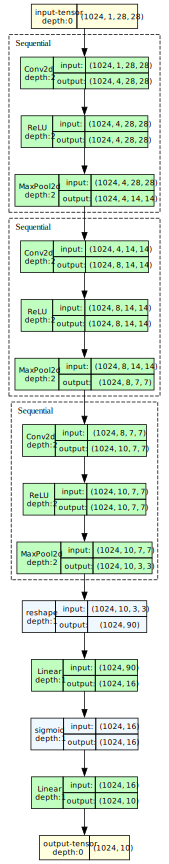

In [77]:
# !pip install torchview
from torchview import draw_graph
model_graph = draw_graph(
    model, 
    input_size=(config['batch_size'],1,28,28), 
    expand_nested=True
    )
model_graph.visual_graph